In [2]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from geopy.distance import vincenty
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

# Acquisition

In [ ]:
data = pd.read_csv('311_Service_Requests_from_2015.csv')

In [ ]:
# A fifth of these have no address, so the 1/10th with no latitude is probably as good as it gets.
for col in ['Incident Address', 'Latitude', 'Longitude', 'Descriptor']:
    print(col + '\t' + str(data[col].isnull().mean()))

In [ ]:
data[['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type', 'Descriptor', 'Latitude', 'Longitude']].to_csv('311_2015_short.csv')

In [ ]:
data = pd.read_csv('311_2015_short.csv')

# Filtering

We find that Complaint Types with descriptors containing "flood" can be either "Sewer", "Public Toilet" or some sort of lighting. By inspection, only Sewer is relevant.

In [ ]:
flood_data = data[(data.Descriptor.fillna('').str.lower().str.contains('flood'))
                  & (data['Complaint Type'] == 'Sewer')
                  & (data.Latitude.notnull())]

# delete accidentally introduced column
del flood_data['Unnamed: 0']

# clean up column names
flood_data.columns = [col.lower().replace(' ', '_') for col in flood_data.columns]

flood_data.created_date = pd.to_datetime(flood_data.created_date)

In [7]:
flood_data.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,latitude,longitude,created_date_float
0,30740992,2015-05-31 19:19:00,06/18/2015 08:30:00 AM,Sewer,Street Flooding (SJ),40.709027,-73.780835,1433114340
1,30957585,2015-06-28 06:41:00,06/29/2016 10:10:00 AM,Sewer,Street Flooding (SJ),40.672068,-73.777982,1435488060
2,30958236,2015-06-28 07:05:00,07/15/2015 11:20:00 AM,Sewer,Street Flooding (SJ),40.665102,-73.738892,1435489500
3,31502955,2015-09-10 18:58:00,09/18/2015 10:53:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.656512,-73.834222,1441925880
4,31861036,2015-10-28 11:12:00,11/12/2015 09:00:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.576310,-73.857053,1446045120


In [6]:
flood_data.shape

(9188, 8)

In [15]:
flood_data.dtypes

unique_key                     int64
created_date          datetime64[ns]
closed_date                   object
complaint_type                object
descriptor                    object
latitude                     float64
longitude                    float64
created_date_float             int64
dtype: object

In [ ]:
flood_data.to_csv('311_2015_flooding.csv', index=False)

In [1]:
flood_data = pd.read_csv('311_2015_flooding.csv', parse_dates=[1])

NameError: name 'pd' is not defined

# Analysis

In [8]:
# How many days of the year have flooding data?
flood_data.created_date.dt.dayofyear.nunique()

363

In [108]:
def plot_location():
    
    data = flood_data#[flood_data.created_date.dt.weekofyear == day_of_year]
    
    plt.plot(data.latitude, data.longitude, '.', alpha=0.1)

plot_location()

NameError: name 'flood_data' is not defined

## Normalize

In [13]:
def normalize(d, k=1):
    _min = min(d)
    _max = max(d)
    
    return k*(d - _min)/(_max - _min)

In [14]:
flood_data.sort_values('created_date_float', inplace=True)

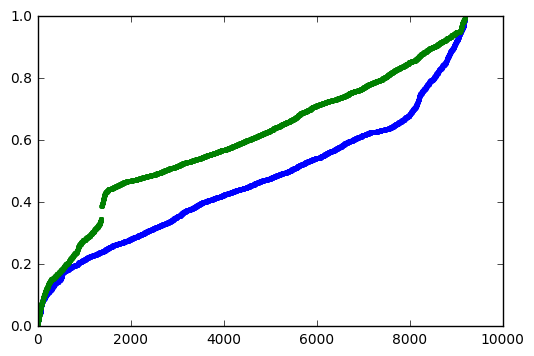

In [59]:
plt.plot(flood_data.latitude_float.sort_values().values, '.');
plt.plot(flood_data.longitude_float.sort_values().values, '.');

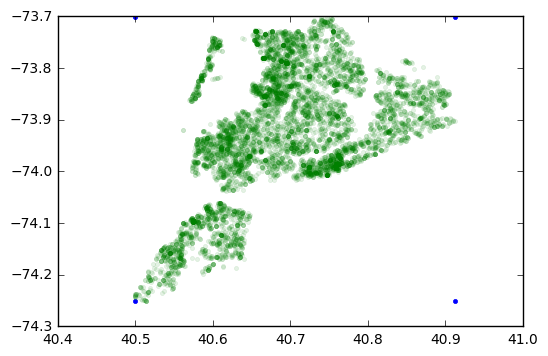

In [34]:
plt.plot(
     # upper-left # lower-left # lower-right
    [flood_data.latitude.max(),  flood_data.latitude.min(), flood_data.latitude.min(), flood_data.latitude.max()],
    [flood_data.longitude.min(), flood_data.longitude.min(), flood_data.longitude.max(), flood_data.longitude.max()],
    '.')
plt.plot(flood_data.latitude, flood_data.longitude, '.', alpha=0.1)

## 1-step clustering

In [54]:
flood_data.cluster.nunique()

55

In [55]:
def cluster_attributes(cluster):
    
    latitude_max = cluster.latitude.max()
    latitude_min = cluster.latitude.min()
    longitude_max = cluster.longitude.max()
    longitude_min = cluster.longitude.min()
    
    time_diameter = vincenty((latitude_max, longitude_min), (latitude_min, longitude_max)).miles
    
    space_diameter = cluster.created_date.max() - cluster.created_date.min()

    return [space_diameter, time_diameter, cluster.shape[0]]

TODO
- Find eps in miles
- Filter by short floods

In [52]:
time_scaler = 3.2
flood_data['created_date_float'] = normalize(flood_data.created_date.dt.strftime("%s").astype(int), time_scaler)
flood_data['latitude_float'] = normalize(flood_data.latitude)
flood_data['longitude_float'] = normalize(flood_data.longitude)

X = flood_data[['latitude_float', 'longitude_float', 'created_date_float']].as_matrix()
flood_data['cluster'] = DBSCAN(eps=0.01, min_samples=5).fit_predict(X)

print('EPS is 0.01 = {} days = ??? miles'.format(0.01*(365/time_scaler)))

floods = pd.DataFrame(list(flood_data.groupby('cluster').apply(cluster_attributes).values),
                   columns=['space_diameter', 'time_diameter', 'n_reports'])

EPS is 0.01 = 1.140625 days = ??? miles


In [53]:
floods

,space_diameter,time_diameter,n_reports
0,40.617198,363 days 12:14:00,8818
1,0.240394,0 days 04:00:00,5
2,0.340325,0 days 00:10:00,5
3,0.226347,0 days 01:28:00,5
4,0.178866,0 days 00:22:00,5
5,0.352741,0 days 12:06:00,5
6,0.475637,0 days 02:22:00,9
7,0.043849,0 days 01:48:00,5
8,0.237587,1 days 02:50:00,6
9,0.275642,0 days 04:36:00,5


In [102]:
flood_data[flood_data.cluster != -1].sort_values(['cluster', 'created_date']).to_csv('311_2015_floods.csv')

,unique_key,created_date,closed_date,complaint_type,descriptor,latitude,longitude,created_date_float,cluster,latitude_float,longitude_float
644,29662889,2015-01-08 09:26:00,01/12/2015 11:50:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.843433,-73.905145,0.060796,0,0.832316,0.628274
655,29666156,2015-01-08 09:58:00,01/10/2015 11:15:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.844511,-73.907572,0.060992,0,0.834920,0.623863
649,29664462,2015-01-08 10:22:00,01/18/2015 09:00:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.845911,-73.908369,0.061139,0,0.838304,0.622415
646,29662903,2015-01-08 11:47:00,01/12/2015 11:15:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.843799,-73.906752,0.061658,0,0.833201,0.625352
661,29672567,2015-01-08 13:26:00,01/16/2015 09:45:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.843453,-73.905864,0.062263,0,0.832364,0.626967
675,29687439,2015-01-10 15:06:00,01/11/2015 09:15:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.867910,-73.868289,0.080481,1,0.891461,0.695252
674,29686669,2015-01-10 15:10:00,01/11/2015 10:05:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.869695,-73.867222,0.080505,1,0.895776,0.697191
679,29691016,2015-01-10 15:12:00,01/11/2015 09:45:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.867889,-73.867276,0.080517,1,0.891412,0.697092
680,29691048,2015-01-10 15:13:00,01/11/2015 10:40:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.871441,-73.867157,0.080524,1,0.899994,0.697309
678,29689932,2015-01-10 15:16:00,01/11/2015 09:00:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.866590,-73.868328,0.080542,1,0.888271,0.695182


In [53]:
flood_data.sort_values('cluster', ascending=False)[
    ['created_date', 'created_date_float', 'longitude_float', 'latitude_float', 'cluster']]

,created_date,created_date_float,longitude_float,latitude_float,cluster
3536,2015-05-31 19:57:00,150.505496,0.592884,0.422483,2
3601,2015-05-31 19:57:00,150.505496,0.719996,0.398676,2
3582,2015-05-31 19:57:00,150.505496,0.609344,0.473458,2
3634,2015-05-31 19:57:00,150.505496,0.615572,0.455975,2
3586,2015-05-31 19:57:00,150.505496,0.845423,0.454891,2
844,2015-01-18 15:57:00,17.200946,0.107435,0.079574,1
811,2015-01-18 15:57:00,17.200946,0.868094,0.472389,1
969,2015-01-18 15:57:00,17.200946,0.790926,0.638801,1
869,2015-01-18 15:57:00,17.200946,0.818586,0.412925,1
850,2015-01-18 15:57:00,17.200946,0.730134,0.440045,1


## 2-step clustering

In [2]:
import sys

In [3]:
pre_import_modules = set(s.split('.')[0] for s in sys.modules.keys())

In [19]:
# Turn off chained assignment warning
pd.options.mode.chained_assignment = None

In [3]:
from collections import OrderedDict 

In [4]:
from collections import defaultdict, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from geopy.distance import vincenty
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

In [5]:
import time
import datetime

In [6]:
class Experiment():
    
    def __init__(self):
        self._steps = []
        self._steps_results = OrderedDict()
        
        self.imports()
        self.load()
        
    
    def _run(self):
        
        for step in self._steps:
            
            step()

    def report(self):
    
        report = ''
        
        for step_name in self._steps:
            
            step = getattr(self, step_name)
            
            report += step.__doc__.format(**self.__dict__)
        
        print(report)
                        
    def load(self):
        
        raise NotImplementedError
        
    
    def imports(self):
        
        raise NotImplementedError
        
    def __getitem__(self, arg):
        
        return self._steps_results[arg]
        

In [74]:
del Experiment, e

In [7]:
def add_step(function):
    
    def new_function(self, *args, **options):
        
        Run = namedtuple('Run', ['runtime', 'timestamp',])
        name = function.__name__
        
        if name not in self._steps:
            self._steps.append(name)
        
        start = time.monotonic()
        
        result = function(self, *args, **options)
        
        end = time.monotonic()
        
        # TODO Find a place to put this!
        run = Run(
            end - start,
            datetime.datetime.isoformat(datetime.datetime.today())
            )
        
        self._steps_results[name] = result
        
        return result

    new_function.__doc__ = function.__doc__
    setattr(Experiment, function.__name__, new_function)
    
    return new_function

In [8]:
class Flood(Experiment):
    
    def imports(self):
        pass

    def load(self):
        
        self.data_year = 2015
        self.flood_data = pd.read_csv('311_2015_flooding.csv', parse_dates=[1])
    
e = Flood()

In [199]:
@add_step
def plot_flood_reports(self):
    # NB A couple days might be missing from this plot because they had zero reports of flooding
    plt.figure(figsize=(8, 2))
    plt.plot(self.flood_data.groupby(self.flood_data.created_date.dt.dayofyear).size(), '.-')
    plt.axhline(self.storm_period_threshold, color='black', linestyle='dashed')
    plt.xlabel('Day of year')
    plt.xlim(0, 365)
    plt.ylabel('Number of flooding reports')
    plt.savefig('flood_reports.png', dpi=200, bbox_inches='tight')

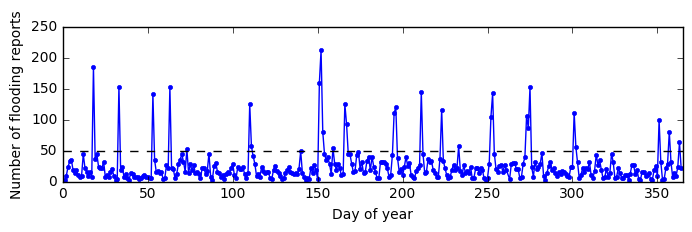

In [200]:
e.plot_flood_reports()

In [9]:
@add_step
def get_storm_periods(self):
    """
    In the first step, consecutive days with more than {storm_period_threshold} reports of flooding were classed as
    storm periods. For {data_year}, we identified {number_of_storm_periods} storms.
    """
    self.storm_period_threshold = 50
    
    is_storm_periods = self.flood_data.groupby(self.flood_data.created_date.dt.dayofyear).size() > self.storm_period_threshold
    
    storm_periods = defaultdict(list)
    i = 0
    is_yesterday = False
    
    for today, is_today in zip(is_storm_periods.index, is_storm_periods):
        
        # if yesterday was False, a new run is beginning
        if not is_today and is_yesterday:
            i += 1
        
        if is_today:
            storm_periods[i].append(today)
            
        is_yesterday = is_today
    
    self.number_of_storm_periods = len(storm_periods)
    self.storm_periods = storm_periods

In [10]:
@add_step
def eps_to_miles(self):
    
    latitude_max = self.flood_data.latitude.max()
    latitude_min = self.flood_data.latitude.min()
    longitude_max = self.flood_data.longitude.max()
    longitude_min = self.flood_data.longitude.min()
    
    #print(list(zip((latitude_max, longitude_min), 
    #         (latitude_min, longitude_min), 
    #         (latitude_max, longitude_min), 
    #         (latitude_max, longitude_max))))
    
    #plt.plot(*list(zip(
    #         (latitude_max, longitude_min), 
    #         (latitude_min, longitude_min), 
    #         (latitude_max, longitude_min), 
    #         (latitude_max, longitude_max))), '.')
    #plt.xlabel('latitude')
    #plt.ylabel('longitude')
    
    distance_lat_miles = vincenty((latitude_max, longitude_min), (latitude_min, longitude_min)).miles
    distance_lat_units = latitude_max - latitude_min
    
    distance_long_miles = vincenty((latitude_max, longitude_min), (latitude_max, longitude_max)).miles
    distance_long_units = longitude_max - longitude_min
    
    self.miles_per_deg_lat = distance_lat_miles/distance_lat_units
    self.miles_per_deg_long = distance_long_miles/distance_long_units

In [201]:
@add_step
def cluster_storms_tune_eps(self):

    self.n_floods_by_eps = []
    self.n_outliers_by_eps = []
    self.eps_range = np.arange(0.00001, 0.050, 0.001)
    
    for eps in self.eps_range:
    
        self.cluster_storms(eps)
        self.n_outliers_by_eps.append(self.n_outliers)
        self.n_floods_by_eps.append(self.n_floods)

    self.eps_range_miles = self.miles_per_deg_lat * self.eps_range

@add_step
def plot_n_floods_n_outliers_by_eps(self):
    
    plt.plot(self.eps_range_miles, self.n_floods_by_eps)
    plt.xlabel('Neighborhood radius in miles*')
    plt.ylabel('Number of flood clusters')
    plt.axvline(0.25, linestyle='dashed', color='black')
    plt.twinx()
    # spoof a line to get the label added to the legend
    plt.plot(np.nan, label='Flood clusters')
    plt.plot(self.eps_range_miles, self.n_outliers_by_eps, color='green', label='Outliers')
    plt.ylabel('Number of outlier points')
    plt.legend()
    plt.savefig('n_floods_n_outliers_by_esp.png', dpi=200, bbox_inches='tight')

In [14]:
def cluster_attributes(cluster):
    
    latitude_max = cluster.latitude.max()
    latitude_min = cluster.latitude.min()
    longitude_max = cluster.longitude.max()
    longitude_min = cluster.longitude.min()
    
    space_diameter = vincenty((latitude_max, longitude_min), (latitude_min, longitude_max)).miles    
   
    time_diameter = cluster.created_date.max() - cluster.created_date.min()
    
    time_start = cluster.created_date.min()
    time_end = cluster.created_date.max()
    
    space_center_latitude = cluster.latitude.mean()
    space_center_longitude = cluster.longitude.mean()    

    return [time_start, time_end, space_center_latitude, space_center_longitude,
            space_diameter, time_diameter, cluster.shape[0]]

In [143]:
def cluster_storms(eps):
    
    self.floods = []
    self.eps = eps
    self.minimum_flood_reports = 3
    self.n_outliers = 0
    
    for storm_number, storm_days in self.storm_periods.items():
        
        storm_floods = self.flood_data[self.flood_data.created_date.dt.dayofyear.isin(set(storm_days))]
        storm_floods_matrix = storm_floods[['latitude', 'longitude']].as_matrix()
        
        #print(storm_floods_matrix)
        dbscan = DBSCAN(eps=self.eps, min_samples=self.minimum_flood_reports)
        
        storm_floods['cluster'] = dbscan.fit_predict(storm_floods_matrix)
        
        is_outlier = (storm_floods.cluster == -1)
        self.n_outliers += is_outlier.sum()
        storm_floods = storm_floods[~is_outlier]
        
        floods = list(storm_floods.groupby('cluster').apply(cluster_attributes).values)
        floods = [flood + [storm_number] for flood in floods]
        #print(floods)
        self.floods.extend(floods)
    
    
    self.floods = pd.DataFrame(self.floods,
             columns=['time_start', 'time_end', 'latitude_center', 'longitude_center',
                     'diameter', 'duration', 'number_of_reports', 'storm_number'])
    self.n_floods = len(self.floods)
    
    return floods, n_outliers

In [85]:
e.get_storm_periods()

In [86]:
e.cluster_storms_tune_eps()

In [58]:
e.eps_to_miles()

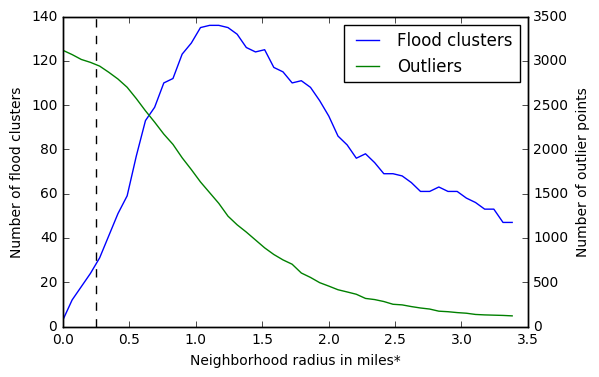

In [202]:
e.plot_n_floods_n_outliers_by_eps()

In [144]:
e.cluster_storms(0.25/e.miles_per_deg_long)
e.n_floods

188

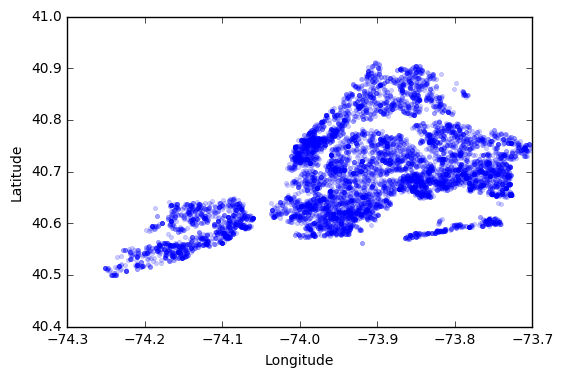

In [203]:
plt.plot(e.flood_data['longitude'], e.flood_data['latitude'], '.', alpha=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('flood_reports_by_location.png', dpi=200, bbox_inches='tight')

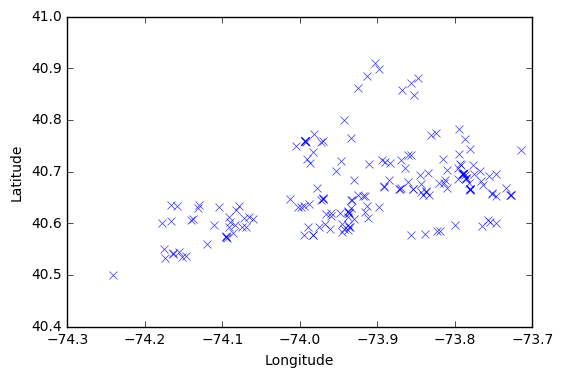

In [204]:
plt.plot(e.floods['longitude_center'], e.floods['latitude_center'], 'x', alpha=0.8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('flood_clusters_by_location.png', dpi=200, bbox_inches='tight')

In [184]:
#e.eps_to_miles()
#e.get_storm_periods()
e.cluster_storms(0.004)